<a href="https://colab.research.google.com/github/albim72/BOOTCAMP_PYTHON_II/blob/main/klasyfikacja_tekstu_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1",url,untar=True,cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

84125825/84125825 [==============================] - 22s 0us/step


In [3]:
os.listdir(dataset_dir)

['train', 'README', 'test', 'imdbEr.txt', 'imdb.vocab']

In [4]:
from tensorflow.python import train
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_neg.txt',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsup',
 'pos',
 'neg',
 'urls_unsup.txt',
 'unsupBow.feat']

In [5]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [6]:
#tworzenie zbiorów danych
remove_dir = os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print(f"Recenzja: {text_batch.numpy()[i]}")
    print(f"Etykieta: {label_batch.numpy()[i]}")

Recenzja: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Etykieta: 0
Recenzja: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [10]:
print(f"etykieta 0 oznacza {raw_train_ds.class_names[0]}")
print(f"etykieta 1 oznacza {raw_train_ds.class_names[1]}")

etykieta 0 oznacza neg
etykieta 1 oznacza pos


In [12]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


**PRZYGOTOWANIE ZBIORU DO SZKOLENIA**
<br>Procesy
1.   Standaryzacja
2.   Tokenizacja
3. Wektoryzacja



In [14]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />',' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

In [15]:
from numpy.lib.function_base import vectorize
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [17]:
train_text = raw_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [18]:
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [19]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print(f"Recenzja: {first_review}")
print(f"Etykieta: {raw_train_ds.class_names[first_label]}")
print(f"Widok zwektoryzowany: {vectorize_text(first_review,first_label)}")

Recenzja: b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.'
Etykieta: neg
Widok zwektoryzowany: (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,

In [21]:
print(f"1287 ---> {vectorize_layer.get_vocabulary()[1287]}")
print(f"313 ---> {vectorize_layer.get_vocabulary()[313]}")
print(f"251 ---> {vectorize_layer.get_vocabulary()[251]}")
print(f"86 ---> {vectorize_layer.get_vocabulary()[86]}")
print(f"Rozmiar słownika: {len(vectorize_layer.get_vocabulary())}")

1287 ---> silent
313 ---> night
251 ---> found
86 ---> great
Rozmiar słownika: 10000


In [22]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

<h2>Konfiguracja zbioru danych pod kątem wydajności</h2>

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

<h1>TWORZENIE MODELU</h1>

In [24]:
embedding_dim = 16

In [25]:
model = tf.keras.Sequential([
    layers.Embedding(max_features+1,embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [26]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
optimizer='adam',
metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [27]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 9s 12ms/step - loss: 0.6645 - binary_accuracy: 0.6943 - val_loss: 0.6159 - val_binary_accuracy: 0.7718
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 0.5500 - binary_accuracy: 0.8012 - val_loss: 0.4989 - val_binary_accuracy: 0.8228
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4447 - binary_accuracy: 0.8462 - val_loss: 0.4202 - val_binary_accuracy: 0.8476
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3782 - binary_accuracy: 0.8669 - val_loss: 0.3735 - val_binary_accuracy: 0.8612
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3352 - binary_accuracy: 0.8802 - val_loss: 0.3448 - val_binary_accuracy: 0.8678
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3038 - binary_accuracy: 0.8889 - val_loss: 0.3259 - val_binary_accuracy: 0.8708
Epoch 7/10
625/625 [==============================] - 5s 8ms/

<h2>OCENA MODELU</h2>

In [28]:
loss, accuracy = model.evaluate(test_ds)
print(f"Strata --> {loss}")
print(f"Dopasowanie --> {accuracy}")

782/782 [==============================] - 13s 16ms/step - loss: 0.3107 - binary_accuracy: 0.8728
Strata --> 0.3106986880302429
Dopasowanie --> 0.8728399872779846


In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

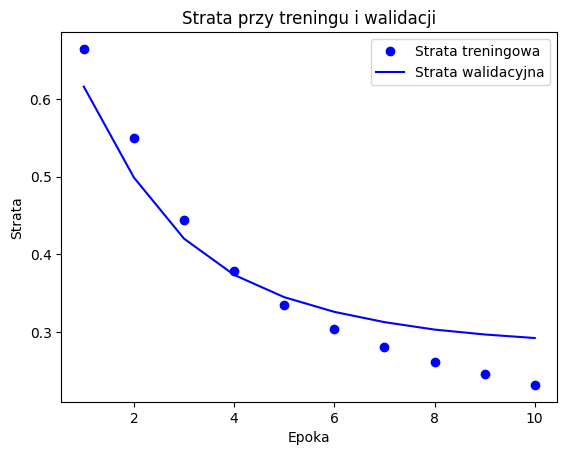

In [30]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,'bo',label='Strata treningowa')
plt.plot(epochs,val_loss,'b',label='Strata walidacyjna')
plt.title('Strata przy treningu i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.show()

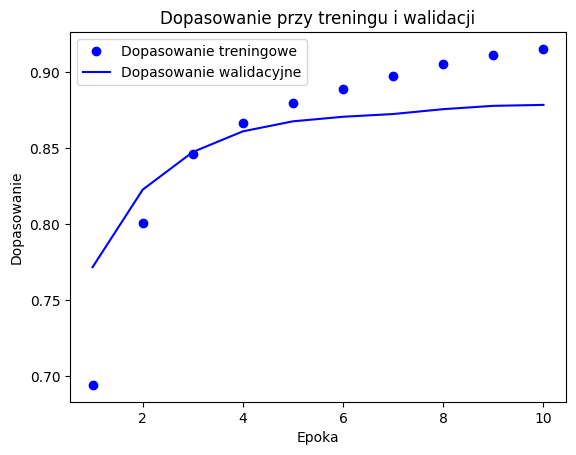

In [31]:
plt.plot(epochs,acc,'bo',label='Dopasowanie treningowe')
plt.plot(epochs,val_acc,'b',label='Dopasowanie walidacyjne')
plt.title('Dopasowanie przy treningu i walidacji')
plt.xlabel('Epoka')
plt.ylabel('Dopasowanie')
plt.legend()
plt.show()